In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm_notebook as tqdm
from scipy.optimize import minimize, least_squares
from scipy.stats import norm
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

In [8]:
def trim(X, percent):
    ''' Trims X with the percent input by removing the top and bottom
    (1-percent)/2 observations and then returns a matrix of binary variables
    indicating rows of X that would not be trimmed
    '''

    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))

    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]

    return np.prod(t_ind, axis = 1)

## Non-Linear Control IV

\begin{align*}
Q_d &= P \beta_d + f(T) + u_d \\
Q_s &= P \beta_s + g(W) + u_s \\
P &= (\beta_d - \beta_s)^{-1} \, \left(  g(W) - f(T) + u_s - u_d \right)  \\
E(u_d \, | \, T, W) &= 0 \\
E(u_s \, | \, T, W) &= 0 \\
cov(W , T) &= 0 \\
\end{align*}

where $f(T)$ is some nonlinear function of $T$ and $g(W)$ is some nonlinear function of $W$. 

Let $\alpha = (\beta_d - \beta_s)^{-1}$. Firstly, note that we have:
\begin{align*}
E(P\,|\,T) &= \alpha (E(W) - f(T)) \\
E(P\,|\,W) &= \alpha (g(W) - E(T)) \\
E(P\,|\,T,W) &= \alpha(g(W) - f(T)) 
\end{align*}

Now, differencing $Q_d$ with its conditional expectation, we have:
\begin{align*}
Q_d - E(Q_d \,|\,T) &= (P - E(P\,|\,T))\beta_d + (f(T) - E(f(T) \,|\,T)) + (u_d - E(u_d|T))\\
&= (\alpha(g(W) - E(W)))\beta_d + 0 + u_d \\
&= (\alpha g(W))\beta_d + c + u_d
\end{align*}
where $c$ absorbs the constant terms.  

Then, since $E(P\,|\,W)$ is simply $\alpha (g(W))$ plus a constant, we regress 
$$Q_d - E(Q_d \,|\,T) \sim E(P\,|\,W)$$ 
with an intercept term to estimate $\beta_d$

### Step by Step Walkthough

#### Variable Generation

In [18]:
n = 2000

# Params
beta_d = -7
beta_s = 3
def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


# Error terms
u_d = np.random.normal(size = n)/3
u_s = np.random.normal(size = n)/3

# Variables
w   = np.random.random(n)
t   = np.random.random(n)
p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
q   = beta_d*p + f(t) + u_d
u_s = q - beta_s*p - g(w)

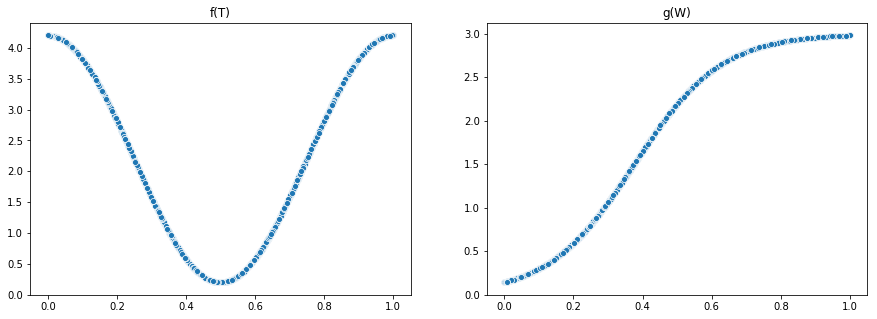

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
sns.scatterplot(t, f(t), ax = ax[0])
ax[0].set_title('f(T)');
sns.scatterplot(w, g(w), ax = ax[1])
ax[1].set_title('g(W)');

#### Conditional Expectations

NW Kernel used to make consistent estimates of $CE(Y\,|\,X=arg)$ where $Y = f(X)$ and $arg$ is the set of points at which to make the conditional expectation estimates. Trimming is needed to ensure consistency.

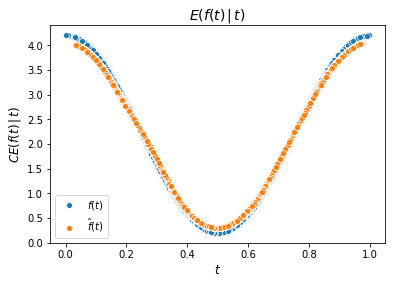

In [20]:
## Testing the CE function (using optimal bandwidth parameter 1/5)

# Trimming t
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.95))
t_trim = t[trim_idx]

# Making conditional estimates of f(t) given t
ce_ft_t  = nparam.KernelReg(endog=[f(t)], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)[0]


# Comparing conditional expectation of f(t) given t with the true value of f(t)
sns.scatterplot(x = t, y = f(t))
sns.scatterplot(x = np.array(t_trim).flatten(), y = np.array(ce_ft_t).flatten())
plt.title('$E(f(t) \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(f(t) \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',                  fontsize = 12);
plt.legend(['$f(t)$', '$\hat{f}(t)$']);

In [21]:
# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T,W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[t,w], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(tw_trim)).fit(tw_trim)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(w_trim)]).fit(w_trim)

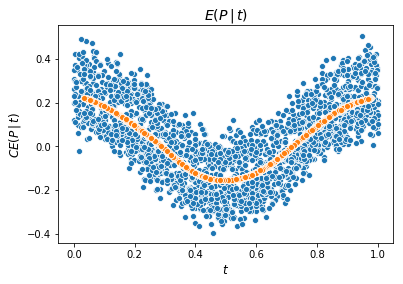

In [22]:
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

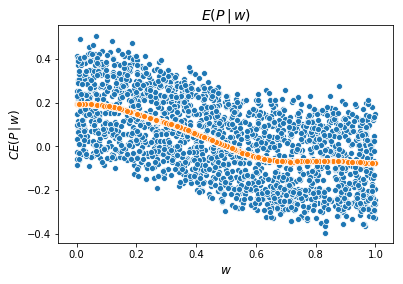

In [23]:
# CE(P|w) is a linear function of g(t) as argued above. 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

#### Main Regression

In [26]:
# Since we trimmed t, we also have to trim prices and quantities by the same index
p_trim = p[trim_idx]
q_trim = q[trim_idx]

data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w ', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
fit.summary(yname = 'Q - CE(Q|T)', xname = ['Intercept', 'βd'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q - CE(Q|T)   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.471e+04
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:50:07   Log-Likelihood:                -152.92
No. Observations:                1900   AIC:                             309.8
Df Residuals:                    1898   BIC:                             320.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2286      0.006     36.606      0.000       0.216       0.241
βd            -7.1859      0.059   -121.296      0.000      -7.302      -7.070
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.270
Skew:                           0.027   Prob(JB):                        0.874
Kurtosis:                       2.978   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [25]:
# Estimation errors
demand_elas_est = fit.params['ce_p_w']
print('Price elasticity of demand estimation error (MAPE):  {0:.2%}'.format(np.abs(1-demand_elas_est/beta_d)))
print('Price elasticity of demand estimation error (MAE):   {0:.2}'.format(np.abs(demand_elas_est-beta_d)))

Price elasticity of demand estimation error (MAPE):  2.66%
Price elasticity of demand estimation error (MAE):   0.19


### Monte Carlo Sim

In [31]:
mc_trials = 100
beta_d_hat_est = []

for trial in tqdm(range(mc_trials)):

    n = 2000
    
    # Params
    beta_d = -7
    beta_s = 3
    def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
    def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


    # Error terms
    u_d = np.random.normal(size = n)/3
    u_s = np.random.normal(size = n)/3

    # Variables
    w   = np.random.random(n)
    t   = np.random.random(n)
    p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
    q   = beta_d*p + f(t) + u_d
    u_s = q - beta_s*p - g(w)

    # Trimming 
    trim_idx = np.where(trim(np.matrix(t).T, percent = 0.9))
    t_trim = t[trim_idx]
    p_trim = p[trim_idx]
    q_trim = q[trim_idx]

    # Conditional expectation estimates
    tw = np.array([t,w]).T
    tw_trim = np.array([t,w]).T[trim_idx]
    w_trim  = np.array(w[trim_idx])
    t_trim  = np.array(t[trim_idx])

    # Estimation of CE(Q | T)
    ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                                  bw=[bw_silverman(t_trim)]).fit(t_trim)

    # Estimation of CE(P | W)
    ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                                 bw=[bw_silverman(w_trim)]).fit(w_trim)

    # Regression
    p_trim = p[trim_idx]
    q_trim = q[trim_idx]

    data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
    data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

    fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w ', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    beta_d_hat_est.append(fit.params['ce_p_w'])

Mean estimate:   -7.1165
Median estimate: -7.1023


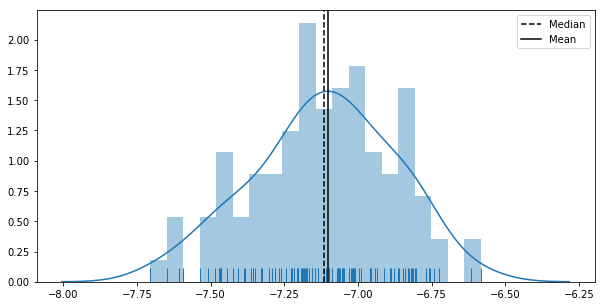

In [32]:
fig = plt.figure(figsize = (10,5))

sns.distplot(beta_d_hat_est, bins = 20, norm_hist = 1, rug = True);
plt.axvline(np.mean(beta_d_hat_est),   color='k', linestyle='--')
plt.axvline(np.median(beta_d_hat_est), color='k', linestyle='-')

plt.legend({'Mean': np.mean(beta_d_hat_est), 'Median':np.median(beta_d_hat_est)});
print('Mean estimate:   {0:.4f}'.format(np.mean(beta_d_hat_est)))
print('Median estimate: {0:.4f}'.format(np.median(beta_d_hat_est)))

In [33]:
print('Estimation error (MAE):  {0:.2}'.format(np.mean(np.abs(np.array(beta_d_hat_est) - beta_d))))
print('Estimation error (RMSE): {0:.2}'.format(np.sqrt(np.mean(np.square(np.array(beta_d_hat_est) - beta_d)))))
print('Estimation error (MAPE): {0:.2%}'.format(np.mean(np.abs(1-np.divide(beta_d_hat_est, beta_d)))))

Estimation error (MAE):  0.21
Estimation error (RMSE): 0.26
Estimation error (MAPE): 3.00%


## Regression with Actual Data

In [373]:
data_df = pd.read_csv('../data/processed/ercot_load_price_2018.csv')

In [374]:
data_df.head()

,date,hour,price,datetime,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd,date_fmt,month,price_rel,load_rel,day
0,01/01/2018,1,27.37,01/01/2018 01:00,9151.190703,-6.1,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.445853,1.765429,1
1,01/01/2018,2,27.46,01/01/2018 02:00,9144.993712,-6.3,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.450608,1.764233,1
2,01/01/2018,3,27.14,01/01/2018 03:00,9141.036615,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.433703,1.763470,1
3,01/01/2018,4,27.71,01/01/2018 04:00,9157.956866,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.463814,1.766734,1
4,01/01/2018,5,27.39,01/01/2018 05:00,9214.333628,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.446910,1.777610,1


In [375]:
wind_output_df = pd.read_csv('../data/wind/wind_output_ercot.csv')[['time-date stamp', 'Total Wind Output, MW']]
wind_output_df.columns = ['datetime', 'wind_output']
wind_output_df['date'] = wind_output_df['datetime'].apply(lambda x: str(x)[:10])
wind_output_df['hour'] = wind_output_df['datetime'].apply(lambda x: int(str(x)[11:13])+1)
wind_output_df.head()

,datetime,wind_output,date,hour
0,01/01/2018 00:00:00,4644,01/01/2018,1
1,01/01/2018 01:00:00,4582,01/01/2018,2
2,01/01/2018 02:00:00,4570,01/01/2018,3
3,01/01/2018 03:00:00,4540,01/01/2018,4
4,01/01/2018 04:00:00,4550,01/01/2018,5


In [376]:
data_df = data_df.merge(wind_output_df.iloc[:,1:], on = ['date', 'hour'])

In [384]:
data_df.groupby(['date'])[['wind_output', 'price', 'load', 'temperature']].mean().to_csv('../data/processed/temp.csv')

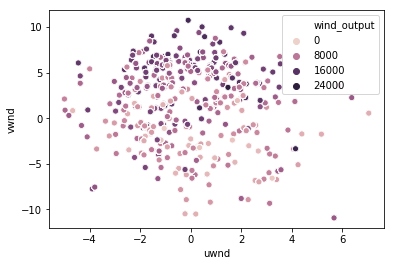

In [383]:
sns.scatterplot(x = 'uwnd', y = 'vwnd', hue = 'wind_output', data = data_df)

In [363]:
# Add logged values
data_df['log_lr']  = np.log(data_df['load_rel'])
data_df.loc[data_df['price']>0,'log_pr'] = np.log(data_df['price_rel'].loc[data_df['price_rel']>0])

# Drop cases where any variable is missing data
reg_data_df = data_df[['wind_output', 'temperature', 'log_lr', 'log_pr', 'hour']].dropna().copy()

In [364]:
cut_low, cut_high = reg_data_df['log_lr'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('log_lr < @cut_high & log_lr > @cut_low')

cut_low, cut_high = reg_data_df['log_pr'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('log_pr < @cut_high & log_pr > @cut_low')

In [365]:
t = np.array(reg_data_df['temperature'])
w = np.array(reg_data_df['wind_output'])
p = np.array(reg_data_df['log_pr'])
q = np.array(reg_data_df['log_lr'])
h = np.array(reg_data_df['hour'])

# Trimming 
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.98))
t_trim = t[trim_idx]
p_trim = p[trim_idx]
q_trim = q[trim_idx]

# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                              bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w_trim)]).fit(w_trim)

# Regression
data_df = pd.DataFrame([q_trim, p_trim, ce_p_w.flatten(), ce_q_t.flatten(), h[trim_idx]]).T
data_df.columns = ['q', 'p','ce_p_w', 'ce_q_t', 'hour']

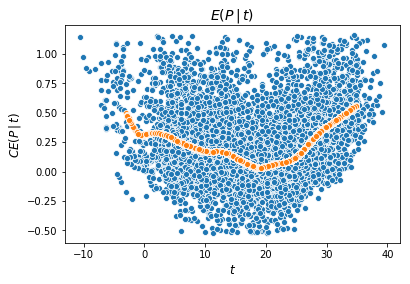

In [366]:
# CE(P|w) is a linear function of f(t) 
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

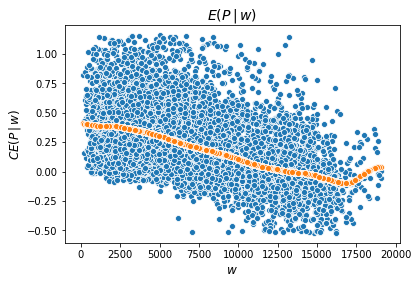

In [367]:
# CE(P|w) is a linear function of g(t) 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

In [369]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.156
Date:                Fri, 22 Mar 2019   Prob (F-statistic):              0.282
Time:                        16:26:26   Log-Likelihood:                 4849.8
No. Observations:                7375   AIC:                            -9696.
Df Residuals:                    7373   BIC:                            -9682.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0031      0.005     -0.646      0.518      -0.012       0.006
ce_p_w         0.0223      0.021      1.075      0.282      -0.018       0.063
==============================================================================
Omnibus:                        5.094   Durbin-Watson:                   0.218
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.781
Skew:                          -0.027   Prob(JB):                       0.0916
Kurtosis:                       2.888   Cond. No.                         7.12
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

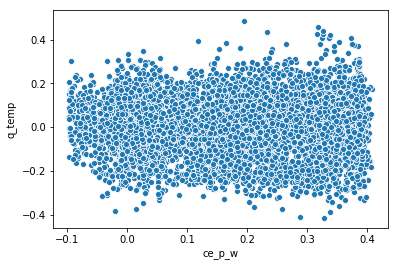

In [370]:
data_df['q_temp'] = data_df['q'] - data_df['ce_q_t']
sns.scatterplot(x = 'ce_p_w', y = 'q_temp', data = data_df)

In [371]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w + C(hour)', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     118.6
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:26:28   Log-Likelihood:                 6550.6
No. Observations:                7375   AIC:                        -1.305e+04
Df Residuals:                    7351   BIC:                        -1.289e+04
Df Model:                          23                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0643      0.007     -9.279      0.000      -0.078      -0.051
C(hour)[T.2.0]     -0.0336      0.003    -10.478      0.000      -0.040      -0.027
C(hour)[T.3.0]     -0.0431      0.005     -9.248      0.000      -0.052      -0.034
C(hour)[T.4.0]     -0.0517      0.005    -10.090      0.000      -0.062      -0.042
C(hour)[T.5.0]     -0.0502      0.006     -8.961      0.000      -0.061      -0.039
C(hour)[T.6.0]     -0.0203      0.006     -3.563      0.000      -0.031      -0.009
C(hour)[T.7.0]      0.0385      0.007      5.487      0.000       0.025       0.052
C(hour)[T.8.0]      0.0509      0.008      6.158      0.000       0.035       0.067
C(hour)[T.9.0]      0.0478      0.009      5.150      0.000       0.030       0.066
C(hour)[T.10.0]     0.0466      0.010      4.758      0.000       0.027       0.066
C(hour)[T.11.0]     0.0433      0.010      4.407      0.000       0.024       0.063
C(hour)[T.12.0]     0.0424      0.009      4.632      0.000       0.024       0.060
C(hour)[T.13.0]     0.0430      0.009      5.001      0.000       0.026       0.060
C(hour)[T.14.0]     0.0470      0.008      5.735      0.000       0.031       0.063
C(hour)[T.15.0]     0.0540      0.008      6.573      0.000       0.038       0.070
C(hour)[T.16.0]     0.0661      0.008      8.154      0.000       0.050       0.082
C(hour)[T.17.0]     0.0919      0.008     12.089      0.000       0.077       0.107
C(hour)[T.18.0]     0.1368      0.007     18.905      0.000       0.123       0.151
C(hour)[T.19.0]     0.1794      0.007     26.765      0.000       0.166       0.193
C(hour)[T.20.0]     0.2001      0.006     33.133      0.000       0.188       0.212
C(hour)[T.21.0]     0.2044      0.006     37.148      0.000       0.194       0.215
C(hour)[T.22.0]     0.1812      0.005     39.089      0.000       0.172       0.190
C(hour)[T.23.0]     0.1258      0.004     35.551      0.000       0.119       0.133
ce_p_w              0.0074      0.023      0.319      0.750      -0.038       0.053
==============================================================================
Omnibus:                       32.177   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.278
Skew:                           0.006   Prob(JB):                     2.43e-10
Kurtosis:                       3.379   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

### Daily

In [329]:
data_df = pd.read_csv('../data/processed/ercot_load_price_2018.csv')
data_df = data_df.groupby(['date'])['temperature', 'wind_speed', 'price_rel', 'load_rel'].mean().reset_index()

# Add logged values
data_df['log_lr']  = np.log(data_df['load_rel'])
data_df.loc[data_df['price_rel']>0,'log_pr'] = np.log(data_df['price_rel'].loc[data_df['price_rel']>0])

# Drop cases where any variable is missing data
reg_data_df = data_df[['wind_speed', 'temperature', 'log_lr', 'log_pr']].dropna().copy()

In [330]:
cut_low, cut_high = reg_data_df['log_lr'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('log_lr < @cut_high & log_lr > @cut_low')

cut_low, cut_high = reg_data_df['log_pr'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('log_pr < @cut_high & log_pr > @cut_low')

cut_low, cut_high = reg_data_df['wind_speed'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('wind_speed < @cut_high & wind_speed > @cut_low')

In [331]:
t = np.array(reg_data_df['temperature'])
w = np.array(reg_data_df['wind_speed'])
p = np.array(reg_data_df['log_pr'])
q = np.array(reg_data_df['log_lr'])

# Trimming 
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.99))
t_trim = t[trim_idx]
p_trim = p[trim_idx]
q_trim = q[trim_idx]

# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                              bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w_trim)]).fit(w_trim)

# Regression
data_df = pd.DataFrame([q_trim, p_trim, ce_p_w.flatten(), ce_q_t.flatten()]).T
data_df.columns = ['q', 'p','ce_p_w', 'ce_q_t']

In [332]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                 0.0002537
Date:                Fri, 22 Mar 2019   Prob (F-statistic):              0.987
Time:                        15:55:32   Log-Likelihood:                 348.03
No. Observations:                 259   AIC:                            -692.1
Df Residuals:                     257   BIC:                            -684.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.067      0.002      0.999      -0.130       0.131
ce_p_w        -0.0033      0.206     -0.016      0.987      -0.407       0.401
==============================================================================
Omnibus:                        2.268   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.322   Jarque-Bera (JB):                2.223
Skew:                          -0.038   Prob(JB):                        0.329
Kurtosis:                       3.447   Cond. No.                         39.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

(0, 168)

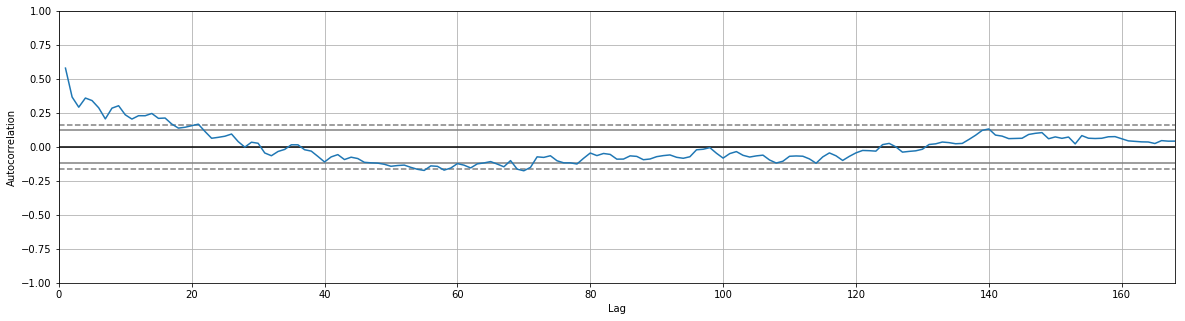

In [333]:
plt.figure(figsize = (20,5))
pd.plotting.autocorrelation_plot(pd.Series(fit.resid))
pylab.xlim([0,24*7])

,wind_speed,temperature,log_lr,log_pr
1,2.334522,-4.339130,0.486588,0.771742
2,-4.726059,2.126087,0.528565,0.997705
3,0.951313,6.582609,0.394634,0.922834
4,5.012610,9.065217,0.229435,0.329862
5,4.371643,9.469565,0.173480,0.127932
7,-5.333386,12.204348,0.091203,0.017959
8,-1.776584,11.900000,0.141121,-0.032256
9,-6.831180,11.643478,0.109619,-0.125287
10,3.717948,11.739130,0.082044,-0.172899
12,4.198288,2.969565,0.308878,0.228590
